In [1]:
import Zygote: @ignore_derivatives
import CSV
import Plots
import Random
import Optimisers
import Zygote
import GLM
using DataFrames
using Lux
using JLD2
using Statistics
using Printf
using SciMLSensitivity
using DifferentialEquations
using StatsBase: sample
using ComponentArrays


include("../../../DCM/src/lib/population.jl");
include("../../../DCM/src/lib/model.jl");
include("../../../DCM/src/lib/error.jl");
include("../../../DCM/src/lib/objectives.jl");
include("../../../DCM/src/lib/compartment_models.jl");
include("../../../DCM/src/lib/callbacks.jl");
include("../../../DCM/src/lib/constrain.jl");
include("../../../DCM/src/lib/lux.helpers.jl");
include("../../../DCM/src/lib/dcm.jl");
include("../../../DCM/src/lib/nn.jl");
include("../../../DCM/src/lib/latent_encoder_decoder.jl");

basic_tgrad(u,p,t) = zero(u);

## Data preparation

In [2]:
# Read Data
file = "../../data/fviii_sim.csv"
df = CSV.read(file, DataFrame)

# One dataframe per patient
df_group = groupby(df, :id);

### Population for DNN (Interventions are covariates)

In [3]:
# Create population 
function create_population_dnn(df_group_inds)
    indvs = Vector{AbstractIndividual}(undef, length(df_group_inds))
    for (i, group) in enumerate(df_group_inds)
        x = Vector{Float32}(group[1, [:weight, :age, :amt]])
        ty = group[(group.mdv .== 0), [:t, :dv]]
        indvs[i] = Individual(x, Float32.(ty.t), Float32.(ty.dv), CallbackSet(); id = group.id[1])
    end
    return Population(indvs);
end

population_dnn = create_population_dnn(df_group);

### Population for Node and DCM (Interventions are callbacks)

In [4]:
# Create population
function create_population(df_group_inds)
    indvs = Vector{AbstractIndividual}(undef, length(df_group_inds))
    for (i, group) in enumerate(df_group_inds)
        x = Vector{Float32}(group[1, [:weight, :age]])
        ty = group[(group.mdv .== 0), [:t, :dv]]
        𝐈 = Matrix{Float32}(group[group.mdv .== 1, [:t, :amt, :rate, :duration]])
        callback = generate_dosing_callback(𝐈)
        indvs[i] = Individual(x, Float32.(ty.t), Float32.(ty.dv), callback; id = group.id[1])
    end
    return Population(indvs);
end
population = create_population(df_group);

## Load models

In [87]:
# DNN
dnn_models = Dict()

for (ix, i) in enumerate(["mymodel-fviii.jld2", "mymodel-fviii-2.jld2", "mymodel-fviii-3.jld2", "mymodel-fviii-4.jld2", "mymodel-fviii-5.jld2"])
    mymodel = JLD2.load(joinpath("../DNN/models/", i))
    model = mymodel["model"]
    dnn_models[ix] = Dict("model" => model)
end

In [97]:
# Encoder decoder
ed_models = Dict()

for (ix, i) in enumerate(["mymodel-fviii.jld2", "mymodel-fviii-2.jld2", "mymodel-fviii-3.jld2", "mymodel-fviii-4.jld2", "mymodel-fviii-5.jld2"]) 
    mymodel = JLD2.load(joinpath("../EncDec/models/", i))
    model = mymodel["model"]
    p = mymodel["p"]
    st = mymodel["st"]

    ed_models[ix] = Dict("model" => model, "p" => p, "st" => st)
end

In [94]:
# Node
node_models = Dict()

for (ix, i) in enumerate(["mymodel-fviii.jld2", "mymodel-fviii-2.jld2", "mymodel-fviii-3.jld2", "mymodel-fviii-6.jld2", "mymodel-fviii-5.jld2"]) #Model 4 is really bad. Change with 6 if needed
    mymodel = JLD2.load(joinpath("../NeuralODE/models/", i))
    node = mymodel["node"]
    p_node = mymodel["p_final"]
    st_node = mymodel["st"]

    node_models[ix] = Dict("node" => node, "p" => p_node, "st" => st_node)
end

In [90]:
# DCM
dcm_models = Dict()

for (ix, i) in enumerate(["mymodel-fviii.jld2", "mymodel-fviii-2.jld2", "mymodel-fviii-3.jld2", "mymodel-fviii-4.jld2", "mymodel-fviii-5.jld2"])
    mymodel = JLD2.load(joinpath("../DCM/models/", i))
    model = mymodel["model"]
    dcm_models[ix] = Dict("model" => model)
end

## Helper functions

### Helper functions for Node

In [19]:
# The function received by ODEFunction must have the form f(u, p, t; kwargs...).
# As the neural network receives [u; x] es inputs, we need to wrap the neural network on top of this function with the correct form.
# Additionally, we add the intervention as another parameter (will be used for the callbacks)
dudt(u, p, t; x, node, st) = node([u; x], p.weights, st)[1] + [p.I, 0.f0]

# Defines a method for the dudt function that accepts kwargs and calls the original dudt function with those arguments.
# The $ syntax (comes from PartialFunctions) is used to partially apply the function with the provided kwargs
dudt(; kwargs...) = dudt$(; kwargs...)

# Forward pass for one individual (solve the ODE)
function forward(model, individual::AbstractIndividual, p, st; dudt = dudt, get_dv::Bool=false, sensealg=nothing, full::Bool=false, interpolate::Bool=false, saveat_ = is_timevariable(individual) ? individual.t.y : individual.t)
    @ignore_derivatives p.I = zero(p.I)
    u0 = isempty(individual.initial) ? zeros(Float32, 2) : individual.initial
    saveat = interpolate ? empty(saveat_) : saveat_
    save_idxs = full ? (1:length(u0)) : 2
    
    f = dudt(; x = individual.x, node = model, st = st)
    ff = ODEFunction{false}(f; tgrad = basic_tgrad)
    prob = ODEProblem{false}(ff, u0, (-0.1f0, maximum(saveat_)), p)
    
    interpolate && (individual.callback.save_positions .= 1)
    sol = solve(prob, Tsit5(),
        save_idxs = save_idxs, saveat = saveat, callback=individual.callback, 
        tstops=individual.callback.condition.times, sensealg=sensealg
    )
    interpolate && (individual.callback.save_positions .= 0)
    return get_dv ? sol[2, :] : sol
end

# Forward pass for population. The Ref function "freezes" the parameters with respect to the dot operator
forward(model, population::Population, p, st; kwargs...) = forward.((model,), population, (p,), (st,); kwargs...)

forward (generic function with 7 methods)

### Helper function for EncoderDecoder

In [20]:
# The forward adjoint method is only defined for populations. Create one for individuals
function forward_ed(model, individual, p, st; kwargs...)
    popind = Population([individual])
    predicted = forward_adjoint(model, popind, p, st; kwargs...)[1]
    return predicted
end;

### Helper function to create callbacks

In [21]:
# Create Intervention Matrix from [(time1, dose1), (time2, dose2), ...] list
function create_intervention_matrix(dose_list; duration = 120)
    if length(dose_list) == 0 return end
    M = []
    for (t, d) in dose_list
        row = [t, d, d * duration, 1/duration]
        push!(M, row)
    end

    # Convert the array of arrays to a matrix
    M = hcat(M...)
    M = M'
end;

## Predict functions

In [22]:
# DNN
predict_dnn(individual, model) = predict(model, individual)[1]

# Encoder decoder
predict_ed(individual, model, p, st) = forward_ed(model, individual, p, st)

# Node
predict_node(individual, node, p, st) = forward(node, individual, ComponentVector(merge(p, (I = 0.f0, ))), st; interpolate = false).u

# DCM
predict_dcm(individual, model) = predict(model, individual; interpolate=false)[1].u;


In [24]:
# Create an individual with dose as callback based on an individual with dose as covariate
function create_individual_callback(individual_dnn)
    doses = [(0,individual_dnn.x[end])] # (Time, Dose)
    I = create_intervention_matrix(doses)
    callback = generate_dosing_callback(I)
    ind = Individual(Float32.(individual_dnn.x[1:end-1]), Float32.(individual_dnn.t), Float32.(zeros(length(individual_dnn.t))), callback)
    return ind
end

## Mean and stdev predictions of 5 models

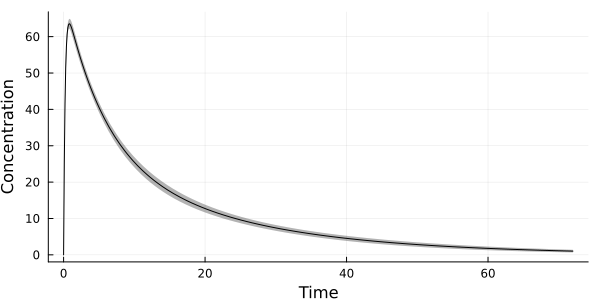

In [103]:
id = 2
time_labels = population[id].t
labels = population[id].y;

# An artificial individual must be created in order to predict "continuously" over time
t = collect(0:0.1:72)
ind_dnn = Individual(Float32.(copy(population_dnn[id].x)), Float32.(t), Float32.(zeros(length(t))), CallbackSet());
ind = create_individual_callback(ind_dnn)

#y = hcat([predict_dnn(ind_dnn, v["model"]) for (k, v) in dnn_models]...)' #DNN
#y = hcat([predict_ed(ind, v["model"], v["p"], v["st"]) for (k, v) in ed_models]...)' #ED
#y = hcat([predict_node(ind, v["node"], v["p"], v["st"]) for (k, v) in node_models]...)' #NODE
y = hcat([predict_dcm(ind, v["model"]) for (k, v) in dcm_models]...)' # DCM

m = vec(mean(y, dims=1))
s = vec(std(y, dims=1))

Plots.plot(ind.t, m, ribbon=s, color = :black, linewidth=1, size=(600,300), title="", xlabel="Time", ylabel="Concentration", label="", fillalpha=0.3)